In [1]:
#importing libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop


from sklearn.model_selection import train_test_split

2024-06-09 18:42:56.836889: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 18:42:56.859719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 18:42:57.239651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset_path = "../data/faces/"

def get_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []

    for label in ["man", "woman"]:
        class_path = os.path.join(dataset_path, label)
        for img_name in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(label)
    
    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(dataset_path)
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)


In [3]:
from tensorflow.keras.utils import Sequence
from concurrent.futures import ThreadPoolExecutor


class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, data_augmentation=None, num_workers=4):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.data_augmentation = data_augmentation
        self.num_workers = num_workers
        self.index = 0
        self.num_samples = len(image_paths)
    
    def __len__(self):
        return np.ceil(self.num_samples / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
            images = list(executor.map(self.load_image, batch_paths))
        
        images = np.array(images)
        
        if self.data_augmentation:
            augmented_images = []
            for img in images:
                img = img.reshape((1,) + img.shape)  # Reshape for the flow method
                augmented_images.append(self.data_augmentation.flow(img, batch_size=1, shuffle=False).next()[0])
            images = np.array(augmented_images)
        
        labels = np.array([1 if label == "woman" else 0 for label in batch_labels])
        return images, labels
    
    def load_image(self, image_path):
        # Load image
        image = cv2.imread(image_path)
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Detect face
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)
        
        # If faces are found, crop to the first detected face
        if len(faces) > 0:
            x, y, w, h = faces[0]
            gray_image = gray_image[y:y+h, x:x+w]
        
        # Resize image to target size
        gray_image = cv2.resize(gray_image, self.target_size)
        # Expand dimensions to match (48, 48, 1)
        gray_image = np.expand_dims(gray_image, axis=-1)
        # Normalize pixel values
        gray_image = gray_image / 255.0
        
        return gray_image
    
    def on_epoch_end(self):
        self.index = 0
        indices = np.arange(self.num_samples)
        np.random.shuffle(indices)
        self.image_paths = [self.image_paths[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]


# ImageDataGenerators for data augmentation (although less useful for grayscale)
train_datagen = ImageDataGenerator(horizontal_flip=True, zoom_range=0.2)
test_datagen = ImageDataGenerator()

# CustomDataGenerators for train and test sets
train_generator = CustomDataGenerator(train_paths, train_labels, batch_size=64, target_size=(48, 48), data_augmentation=train_datagen, num_workers=22)
test_generator = CustomDataGenerator(test_paths, test_labels, batch_size=64, target_size=(48, 48), num_workers=22)



Number of images: 32
Number of labels: 32
[0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1]


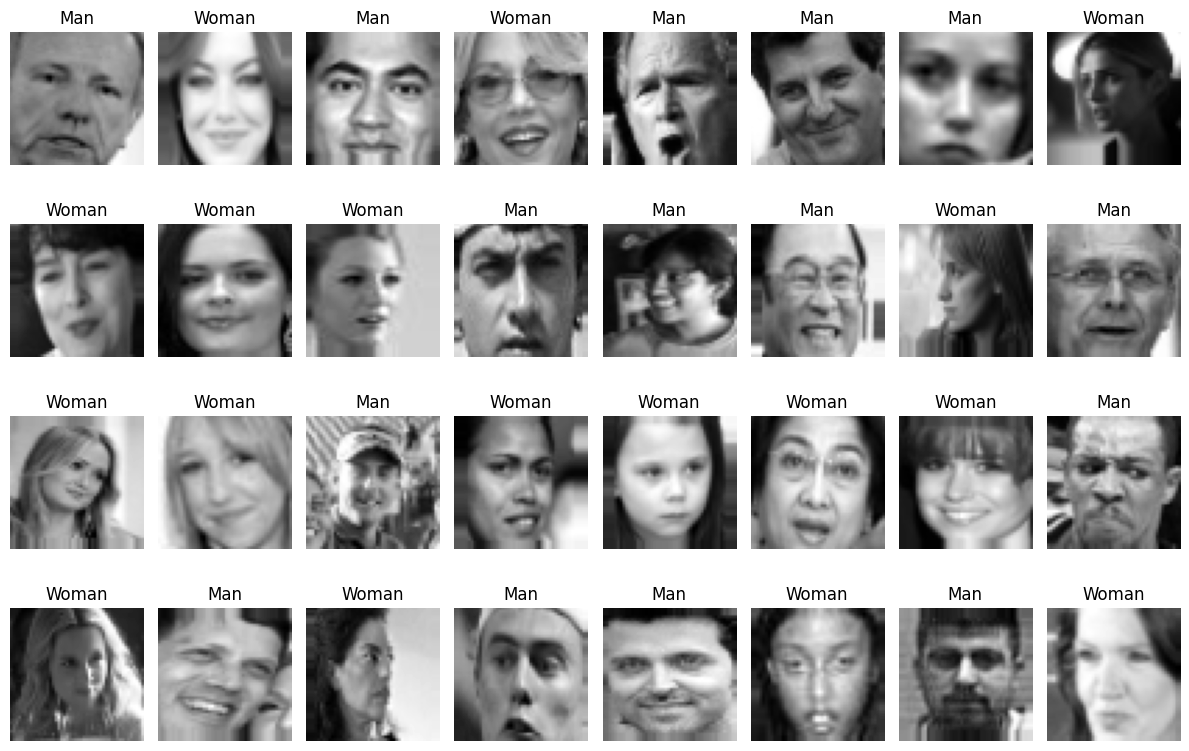

In [17]:

# Get one batch of images and labels
images, labels = train_generator[5]

# Debugging: Print the length of images and labels to ensure they match
print(f'Number of images: {len(images)}')
print(f'Number of labels: {len(labels)}')
print(labels)

# Calculate the number of rows and columns needed
batch_size = len(images)
cols = 8
rows = (batch_size // cols) + (batch_size % cols > 0)

# Plot the images
plt.figure(figsize=(12, 8))
for i in range(batch_size):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title('Woman' if labels[i] == 1 else 'Man')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

# Define the input shape
input_shape = (48, 48, 1)  # For grayscale images, use (48, 48, 1)

# Initialize the model
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 4
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the layers
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected layer 2
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output layer
#num_classes = 2  # Adjust this based on your dataset
model.add(Dense(1, activation='sigmoid'))

2024-06-09 18:43:02.261818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-09 18:43:02.283659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-09 18:43:02.283837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 100

model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0

/home/thor_01/miniconda3/envs/tf/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
history = model.fit_generator(generator=train_generator,
                                epochs=epochs,
                                validation_data = test_generator,
                                callbacks=callbacks_list
                                )

/tmp/ipykernel_17076/898625846.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/100


2024-06-09 18:43:24.175232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-09 18:43:24.708033: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-09 18:43:24.965943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-09 18:43:25.366010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


340/340 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.7615

2024-06-09 18:44:24.219119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


340/340 [==============================] - 74s 214ms/step - loss: 0.4931 - accuracy: 0.7615 - val_loss: 0.8237 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 2/100
340/340 [==============================] - 72s 211ms/step - loss: 0.2998 - accuracy: 0.8710 - val_loss: 0.2518 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 3/100
340/340 [==============================] - 72s 213ms/step - loss: 0.2699 - accuracy: 0.8867 - val_loss: 0.2260 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 4/100
340/340 [==============================] - 71s 210ms/step - loss: 0.2447 - accuracy: 0.9011 - val_loss: 0.2679 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 5/100
340/340 [==============================] - 72s 212ms/step - loss: 0.2282 - accuracy: 0.9066 - val_loss: 0.3806 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 6/100
340/340 [==============================] - 73s 216ms/step - loss: 0.2197 - accuracy: 0.9096 - val_loss: 0.2618 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 7/100
340/340 [==============================] - 72s

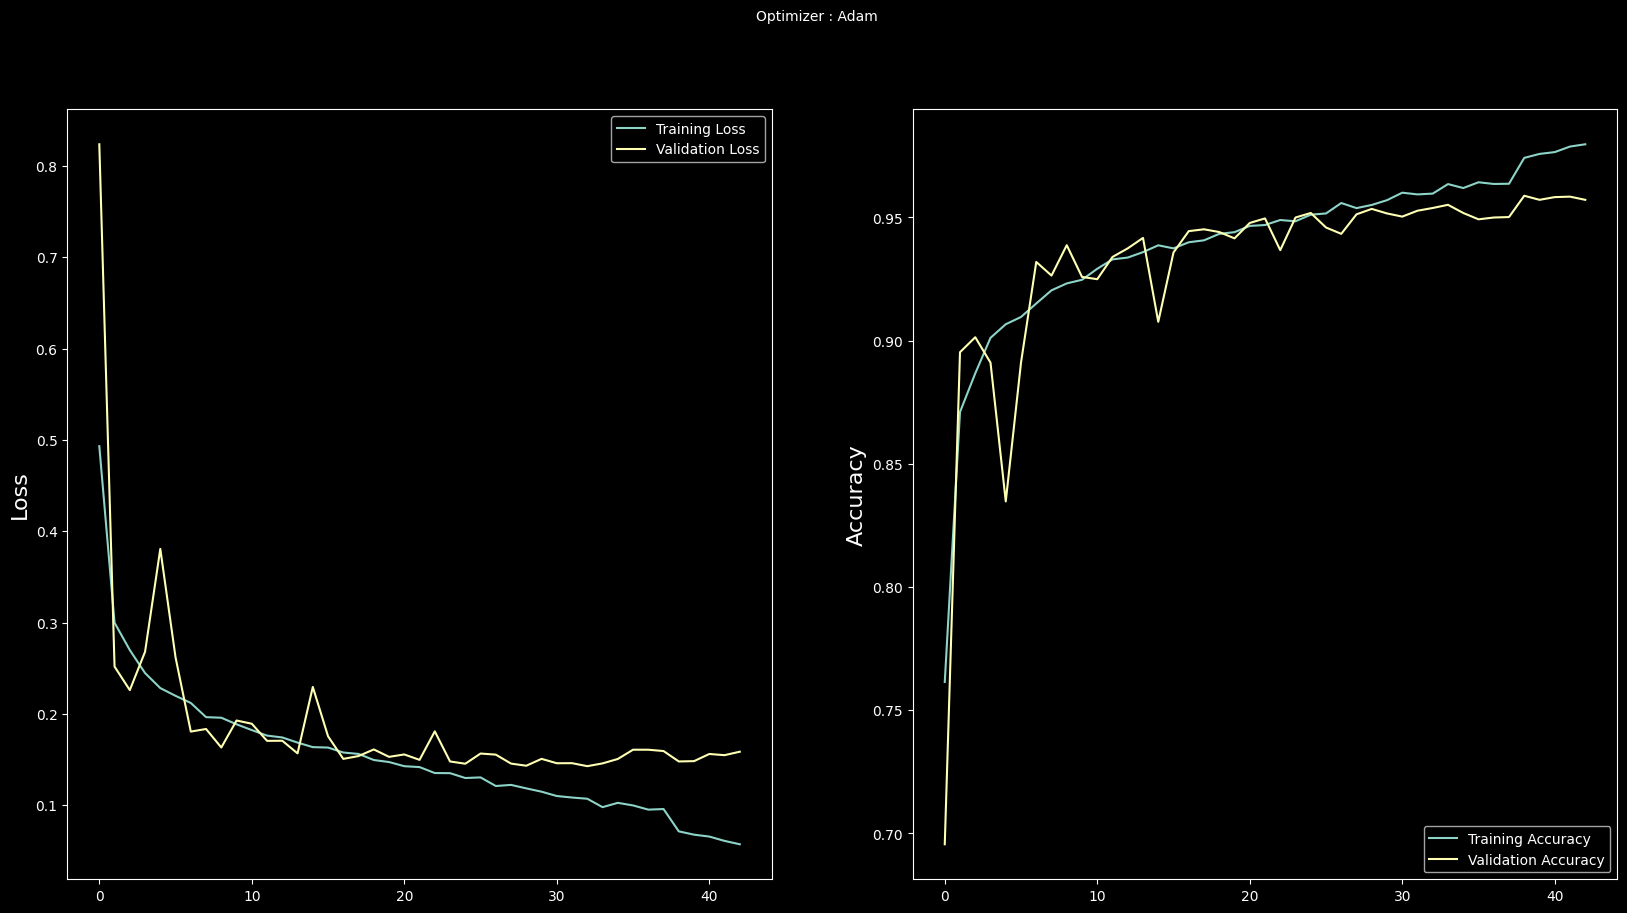

In [7]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [8]:
model.save('gender_VGG_v2.h5')